# Paired Simulations

In [1]:
# import modules
from nbodykit.lab import *
from fastpm.nbkit import FastPMCatalogSource
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Global Parameters
Nc = 128
Length = 499.2 # Mpc  h-1
zobs = 0.3
zinit = 3.
r_s = 10. # smoothing radius

In [3]:
# Setup initial conditions
cosmo = cosmology.Planck15

# Generate IC density field
power = cosmology.LinearPower(cosmo, redshift=zobs)
linear = LinearMesh(power, BoxSize=Length, Nmesh=Nc) # Gaussian realization of linear theory power spectrum

# P(k) of initial field
r = FFTPower(linear, mode="1d")
Pkdelta = r.power['power'].real
k_array = r.power['k']

/home/pcontreras/anaconda3/lib/python3.8/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


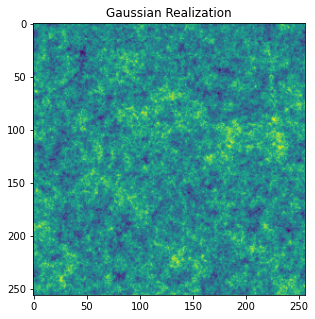

In [4]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(linear.paint(mode='real').preview(axes=[0,1]))
plt.title('Gaussian Realization')
plt.savefig('gaussianfield.pdf')

In [4]:
# functions to obtain initial Gaussian field for paired simulations

def obtain_paired(k, v):
    kk = sum(ki ** 2 for ki in k) # k^2 on the mesh
    Pklinth = power.__call__(kk)
    Pdelta = v.real**2 + v.imag**2
    mask = Pdelta==0
    Pdelta[mask] = 1
    return v*np.sqrt(Pklinth)/np.sqrt(Pdelta)

In [5]:
linearkfix = linear.apply(obtain_paired, mode='complex', kind='wavenumber')

In [6]:
deltafix = linearkfix.to_field(mode='real')
deltafix = FieldMesh(deltafix)

r = FFTPower(deltafix, mode='1d')
PkIC1 = r.power['power'].real

In [7]:
minusdeltafix = -1*linearkfix.to_field(mode='real')
minusdeltafix = FieldMesh(minusdeltafix)

r = FFTPower(minusdeltafix, mode='1d')
PkIC2 = r.power['power'].real

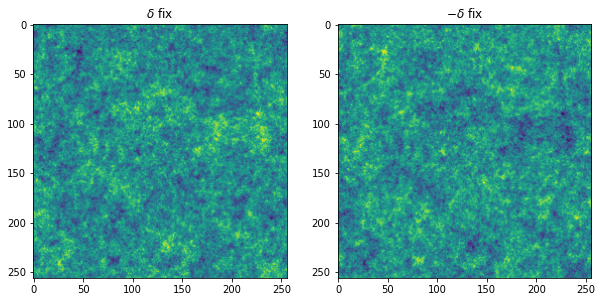

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(deltafix.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title(r'$\delta$ fix')
ax[1].imshow(minusdeltafix.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title(r'$-\delta$ fix')

plt.savefig('input_fields.pdf')

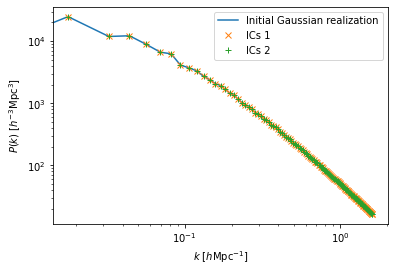

In [48]:
plt.loglog(k_array, Pkdelta, label='Initial Gaussian realization')
plt.loglog(k_array, PkIC1, 'x', label='ICs 1')
plt.loglog(k_array, PkIC2, '+', label='ICs 2')
plt.legend()
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^{3}]$')
plt.savefig('Pk_ICs.pdf')

In [10]:
matter = FastPMCatalogSource(linear, Nsteps=10)
matterfield = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)

/home/pcontreras/anaconda3/lib/python3.8/site-packages/nbodykit/source/mesh/linear.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mask = numpy.bitwise_and.reduce([ki == 0 for ki in k])


In [8]:
matter1 = FastPMCatalogSource(deltafix, cosmo=cosmo, Nsteps=10)
matterfield1 = matter1.to_mesh(resampler='tsc')#, interlaced=True)#, compensated=True)

In [17]:
# matterfield1 = matter1.to_mesh(resampler='tsc', interlaced=True, compensated=True)
# matterfield2 = matter2.to_mesh(resampler='tsc', interlaced=True, compensated=True)

In [10]:
matter2 = FastPMCatalogSource(minusdeltafix, cosmo=cosmo, Nsteps=10)
matterfield2 = matter2.to_mesh(resampler='tsc')#, interlaced=True)#, compensated=True)

Text(0.5, 1.0, 'Simulation 2')

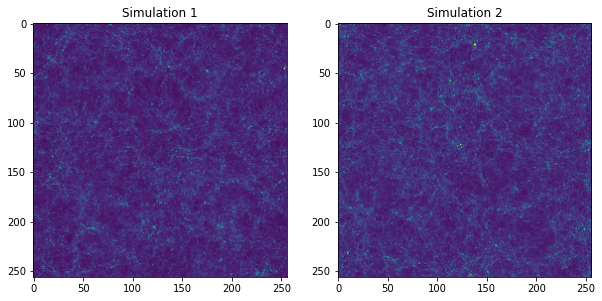

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(matterfield.paint(mode='real').preview(axes=[0,1]))
# ax[0].set_title('Simulation')
ax[0].imshow(matterfield1.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Simulation 1')
ax[1].imshow(matterfield2.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Simulation 2')

#plt.savefig('paired_density_fields.pdf')

In [15]:
# r = FFTPower(matterfield, mode='1d')
# Pk = r.power['power'].real - r.power.attrs['shotnoise']
r = FFTPower(matterfield1, mode='1d')
Pk1 = r.power['power'].real - r.power.attrs['shotnoise']
r = FFTPower(matterfield2, mode='1d')
Pk2 = r.power['power'].real - r.power.attrs['shotnoise']

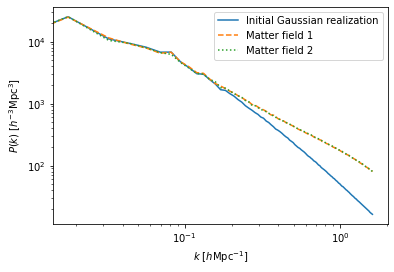

In [16]:
#plt.loglog(k_array, Pk, label='Matter')
plt.loglog(k_array, Pkdelta, label='Initial Gaussian realization')
plt.loglog(k_array, Pk1, '--', label='Matter field 1')
plt.loglog(k_array, Pk2, ':', label='Matter field 2')
plt.legend()
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$')
plt.savefig('Pk_pairedsim_nc128.pdf')

In [11]:
# Run FOF to identify halo groups
DM_part_mass = .5e12
# Simulation 1
fof = FOF(matter1, linking_length=0.4, nmin=5)
halos1 = fof.to_halos(cosmo=cosmo, redshift=zobs, particle_mass=DM_part_mass, mdef='vir')

# Simulation 2
fof = FOF(matter2, linking_length=0.4, nmin=5)
halos2 = fof.to_halos(cosmo=cosmo, redshift=zobs, particle_mass=DM_part_mass, mdef='vir')

In [12]:
nhalos1 = halos1.csize
delta_halos1 = halos1.to_mesh(resampler='tsc', interlaced=True, compensated=True)
r = FFTPower(delta_halos1, mode="1d", Nmesh=Nc)
Pkhalos1 = r.power['power'].real - r.attrs['shotnoise']

nhalos2 = halos2.csize
delta_halos2 = halos2.to_mesh(resampler='tsc', interlaced=True, compensated=True)
r = FFTPower(delta_halos2, mode="1d", Nmesh=Nc)
Pkhalos2 = r.power['power'].real - r.attrs['shotnoise']

print('Halo number density = {:.3e},{:.3e}'.format(nhalos1/(Length**3), nhalos2/(Length**3)))

Halo number density = 9.832e-05,9.954e-05


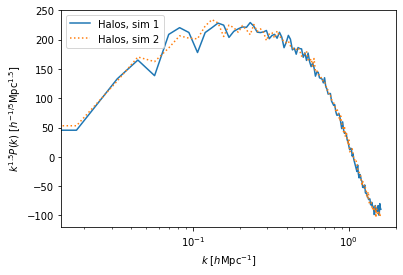

In [29]:
# plt.loglog(k_array, Pk1, label='Matter, sim 1')
# plt.loglog(k_array, Pk2, ':', label='Matter, sim 2')
plt.plot(k_array, k_array**1.5 * Pkhalos1, label='Halos, sim 1')
plt.plot(k_array, k_array**1.5 * Pkhalos2, ':', label='Halos, sim 2')
plt.legend()
plt.xscale('log')
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$k^{1.5} P(k)$ $[h^{-1/5} \mathrm{Mpc}^{1.5}]$')
plt.savefig('Pkhalos_pairedsim.pdf')

Text(0.5, 1.0, 'Simulation 2')

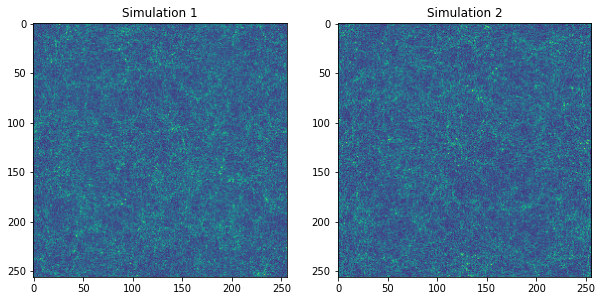

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(delta_halos1.paint(mode='real').preview(axes=[0,1]))
ax[0].set_title('Simulation 1')
ax[1].imshow(delta_halos2.paint(mode='real').preview(axes=[0,1]))
ax[1].set_title('Simulation 2')
#plt.savefig('halo_catalogue.pdf')

In [13]:
# move halos to redshift space

## RSD formula
# vr = 1/(Ha) * (vec(v).vec(r))vec(r)

## Box centered
# Simulation 1
position_origin = halos1['Position'] - 0.5*Length

projection_norm = np.linalg.norm(position_origin, axis=1)

line_of_sight = np.zeros_like(position_origin)
line_of_sight = position_origin/projection_norm[:, np.newaxis]

rsd_factor = (1+zobs) / (100 * cosmo.efunc(zobs))

dot_prod = np.sum(halos1['Velocity']*line_of_sight, axis=1)

halos1['PositionRSD'] = position_origin + rsd_factor*dot_prod[:, np.newaxis]*line_of_sight + 0.5*Length

delta_hRSD1 = halos1.to_mesh(resampler='cic', position='PositionRSD', interlaced=True, compensated=True)
r = FFTPower(delta_hRSD1, mode='1d', Nmesh=Nc)
PkhRSD1 = r.power['power'].real - r.attrs['shotnoise']

# Simulation 2
position_origin = halos2['Position'] - 0.5*Length

projection_norm = np.linalg.norm(position_origin, axis=1)

line_of_sight = np.zeros_like(position_origin)
line_of_sight = position_origin/projection_norm[:, np.newaxis]

rsd_factor = (1+zobs) / (100 * cosmo.efunc(zobs))

dot_prod = np.sum(halos2['Velocity']*line_of_sight, axis=1)

halos2['PositionRSD'] = position_origin + rsd_factor*dot_prod[:, np.newaxis]*line_of_sight + 0.5*Length

delta_hRSD2 = halos2.to_mesh(resampler='cic', position='PositionRSD', interlaced=True, compensated=True)
r = FFTPower(delta_hRSD2, mode='1d', Nmesh=Nc)
PkhRSD2 = r.power['power'].real - r.attrs['shotnoise']

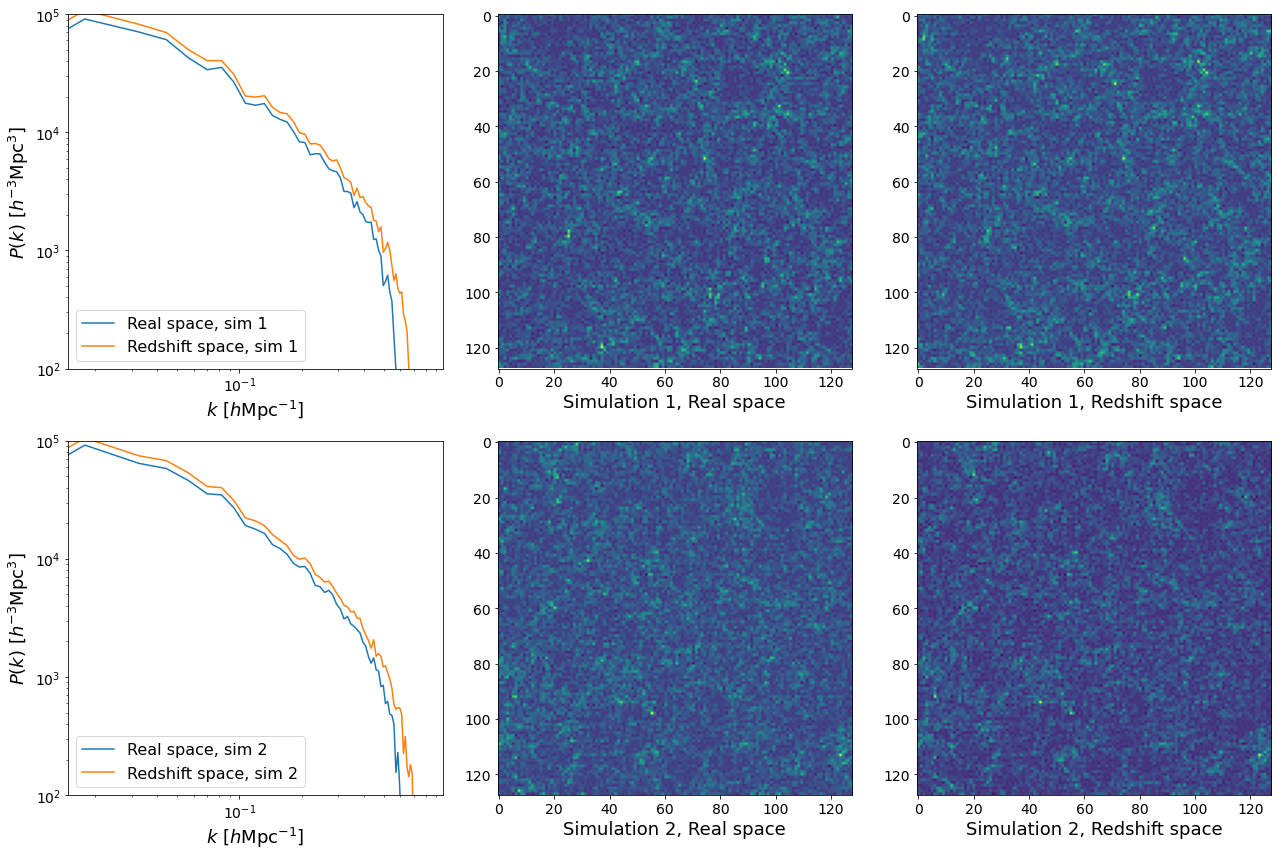

In [20]:
# Compare densifty field in physical and redshift space
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

ax[0,0].loglog(k_array, Pkhalos1, label='Real space, sim 1')
ax[0,0].loglog(k_array, PkhRSD1, label='Redshift space, sim 1')
ax[0,0].legend(fontsize='16')
ax[0,0].set_xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$', fontsize='18')
ax[0,0].set_ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$', fontsize='18')
ax[0,0].set(ylim=(1e2, 1e5))
ax[0,0].tick_params(axis='both', which='major', labelsize=14)

ax[0,1].imshow(delta_halos1.paint(mode='real').preview(axes=[0,1]))
ax[0,1].set_xlabel('Simulation 1, Real space', fontsize='18')#r'$1 + \delta_{g}$')
ax[0,1].tick_params(axis='both', which='major', labelsize=14)

ax[0,2].imshow(delta_hRSD1.paint(mode='real').preview(axes=[0,1]))
ax[0,2].set_xlabel('Simulation 1, Redshift space', fontsize='18')#r'$1 + \delta_{g}^{s}$')
ax[0,2].tick_params(axis='both', which='major', labelsize=14)

ax[1,0].loglog(k_array, Pkhalos2, label='Real space, sim 2')
ax[1,0].loglog(k_array, PkhRSD2, label='Redshift space, sim 2')
ax[1,0].legend(fontsize='16')
ax[1,0].set_xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$', fontsize='18')
ax[1,0].set_ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$', fontsize='18')
ax[1,0].set(ylim=(1e2, 1e5))
ax[1,0].tick_params(axis='both', which='major', labelsize=14)

ax[1,1].imshow(delta_halos2.paint(mode='real').preview(axes=[0,1]))
ax[1,1].set_xlabel('Simulation 2, Real space', fontsize='18')#r'$1 + \delta_{g}$')
ax[1,1].tick_params(axis='both', which='major', labelsize=14)

ax[1,2].imshow(delta_hRSD2.paint(mode='real').preview(axes=[0,1]))
ax[1,2].set_xlabel('Simulation 2, Redshift space', fontsize='18')#r'$1 + \delta_{g}^{s}$')
ax[1,2].tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()

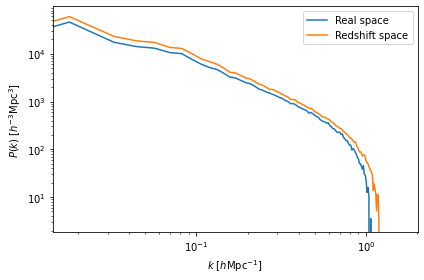

In [22]:
# Compare Pk's in physical and redshift space
plt.loglog(k_array, Pkhalos1, label='Real space')
plt.loglog(k_array, PkhRSD1, label='Redshift space')
plt.legend()
plt.xlabel(r'$k$ $[h \mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$P(k)$ $[h^{-3} \mathrm{Mpc}^3]$')
plt.tight_layout()
# plt.savefig('rsd_pk.pdf')

In [36]:
# Bias from halos PRE
mask = (k_array <= 0.08)*(k_array > 0.02)
bhalos1 = np.mean(np.sqrt(Pkhalos1[mask]/Pk1[mask]))
bhalos2 = np.mean(np.sqrt(Pkhalos2[mask]/Pk2[mask]))

print('bias halos PRE= {:.2f}, {:.2f}'.format(bhalos1, bhalos2))

bias halos PRE= 2.28, 2.25
